# Auto Encoder

## Load Dataset

In [ ]:
DATASET_NAME = 'dataset-5000'
TEST_DATASET_NAME = 'dataset-test'
BATCH_SIZE = 16
MODEL_PATH = 'model/cnn_layernorm'

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from util import GeneratedDataset

trainset = GeneratedDataset(DATASET_NAME, transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = GeneratedDataset(TEST_DATASET_NAME, transforms.ToTensor())
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

## Define CNN based auto-encoder

- 64 * 64 * 3 image input = 12,288
- Cov3 with 32 channel, 3 * 3 * 3 * 32 = 864 parameters
- ReLU
- MaxPool -> 32 * 32 * 32 hidden state = 32768
- Cov3 with 64 channel, 32 * 3 * 3 * 64 = 18432 parameters
- ReLU
- MaxPool -> 16 * 16 * 64 hidden state = 16384
- Cov3 with 128 channel, 64 * 3 * 3 * 128 = 73728 parameters
- ReLU
- MaxPool -> 8 * 8 * 128 = 8192 hidden state
- Full connected 8192 -> **embedding size**

And the decoder works reversely.

In [2]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, embedding_size=32):
        super(Autoencoder, self).__init__()
        self.embedding_size = embedding_size
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.fc1 = nn.Linear(8 * 8 * 128, self.embedding_size)  # Fully connected layer to get 32-length embedding
        self.layer_norm = nn.LayerNorm((self.embedding_size))
        
        # Decoder
        self.fc2 = nn.Linear(self.embedding_size, 8 * 8 * 128)  # Fully connected layer to reshape back to 8x8x128
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)  # Flatten the tensor
        encoded = self.layer_norm(self.fc1(encoded))  # Get the embedding
        decoded = self.fc2(encoded)  # Reshape back to 8x8x128
        decoded = decoded.view(decoded.size(0), 128, 8, 8)
        decoded = self.decoder(decoded)
        return decoded, encoded

In [3]:
from util import train_model_steps, plot_model, count_parameters, calculate_metrics, save_to_file, load_from_file, print_matrix, plot_conf_matrix


def train_model(embedding_size=32, learning_rate=1e-4, weight_decay=1e-5, num_epochs=20):
    # Initialize the model
    model = Autoencoder(embedding_size=embedding_size)
    print(f'Number of parameters: {count_parameters(model)}')

    model_path = f'{MODEL_PATH}/e{embedding_size}.pth'
    stat_path = f'{MODEL_PATH}/e{embedding_size}.pkl'
    if os.path.exists(model_path) and os.path.exists(stat_path):
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        train_losses, test_losses = load_from_file(stat_path)
    else:
        model, train_losses, test_losses = train_model_steps(model, trainloader, testloader, learning_rate, weight_decay, num_epochs)
        # Save the model
        torch.save(model.state_dict(), model_path)
        save_to_file((train_losses, test_losses), stat_path)

    metrics = calculate_metrics(model, testset)
    print_matrix(metrics)
    plot_conf_matrix(metrics['conf_matrix'])
    plot_model(model, train_losses, test_losses, testset)
    return model, train_losses, test_losses

## Evaluation

Testing with embedding size of (down from 8192)
- 2
- 4
- 8
- 16
- 32
- 64

Number of parameters: 407695
Silhouette Score: -0.13750991225242615
Cluster Purity: 0.167
Normalized Mutual Information (NMI): 0.24316956697811168


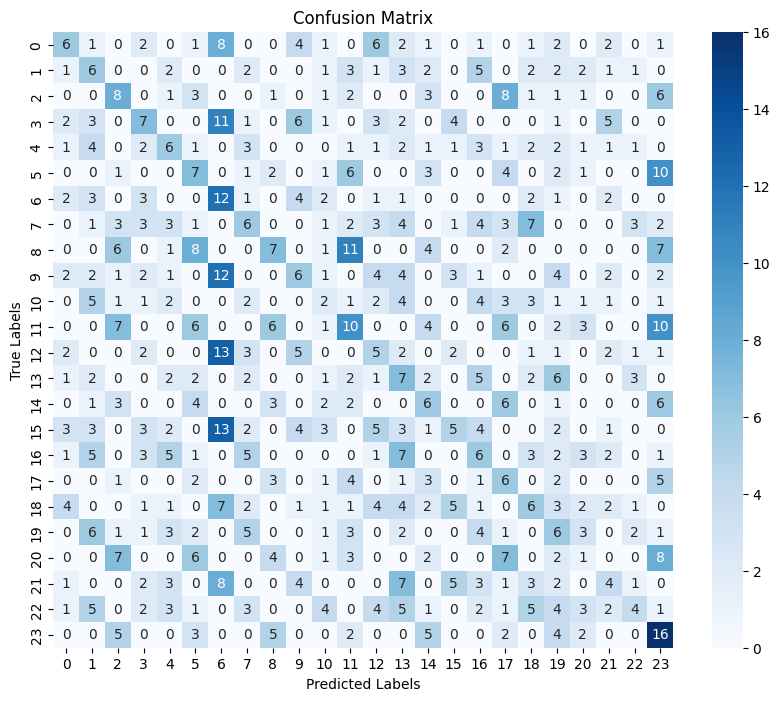

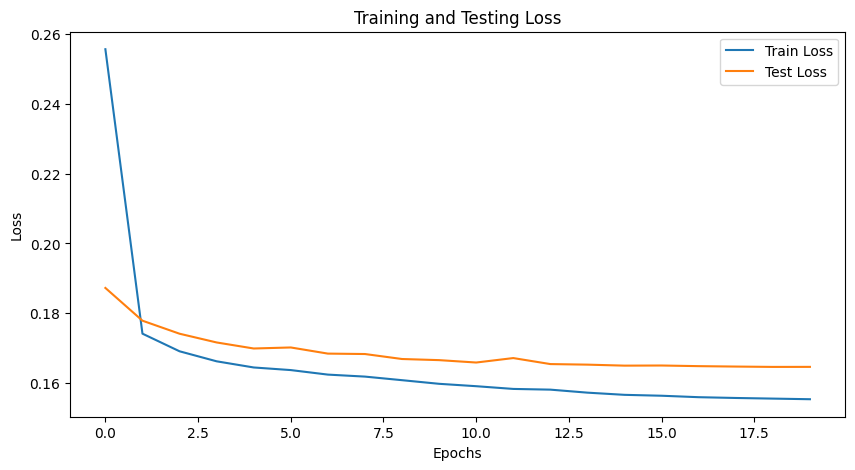

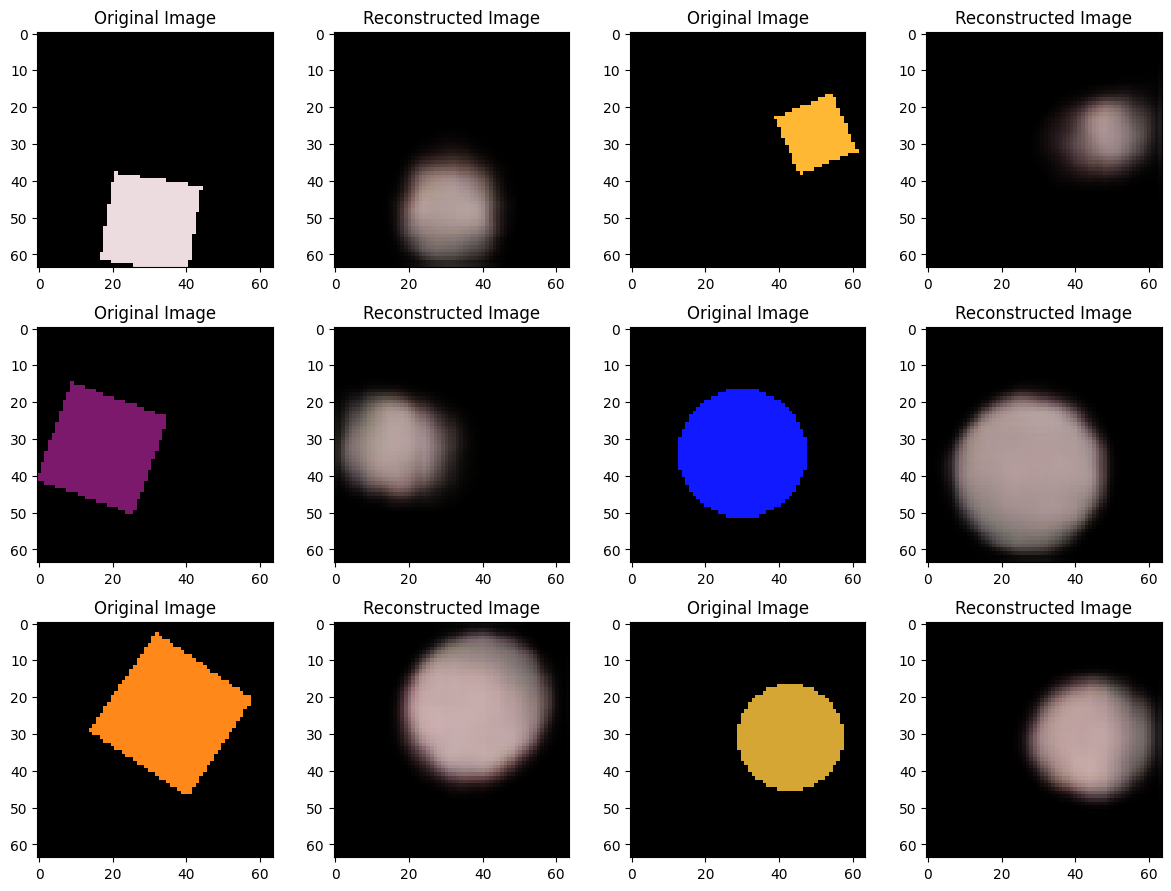

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc1): Linear(in_features=8192, out_features=4, bias=True)
   (layer_norm): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
   (fc2): Linear(in_features=4, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
     (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(

In [4]:
train_model(4)

Number of parameters: 473243
Epoch [1/20], Train Loss: 0.2222, Test Loss: 0.1506
Epoch [2/20], Train Loss: 0.1406, Test Loss: 0.1391
Epoch [3/20], Train Loss: 0.1288, Test Loss: 0.1294
Epoch [4/20], Train Loss: 0.1224, Test Loss: 0.1253
Epoch [5/20], Train Loss: 0.1188, Test Loss: 0.1230
Epoch [6/20], Train Loss: 0.1153, Test Loss: 0.1165
Epoch [7/20], Train Loss: 0.1111, Test Loss: 0.1143
Epoch [8/20], Train Loss: 0.1087, Test Loss: 0.1113
Epoch [9/20], Train Loss: 0.1070, Test Loss: 0.1108
Epoch [10/20], Train Loss: 0.1054, Test Loss: 0.1104
Epoch [11/20], Train Loss: 0.1038, Test Loss: 0.1083
Epoch [12/20], Train Loss: 0.1018, Test Loss: 0.1085
Epoch [13/20], Train Loss: 0.1003, Test Loss: 0.1060
Epoch [14/20], Train Loss: 0.0994, Test Loss: 0.1061
Epoch [15/20], Train Loss: 0.0987, Test Loss: 0.1053
Epoch [16/20], Train Loss: 0.0981, Test Loss: 0.1046
Epoch [17/20], Train Loss: 0.0976, Test Loss: 0.1044
Epoch [18/20], Train Loss: 0.0974, Test Loss: 0.1043
Epoch [19/20], Train Loss:

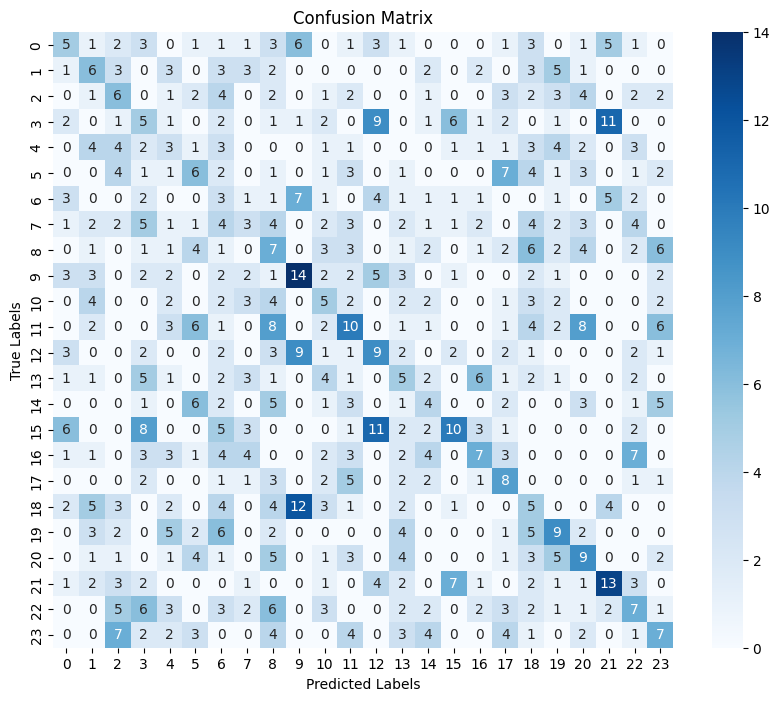

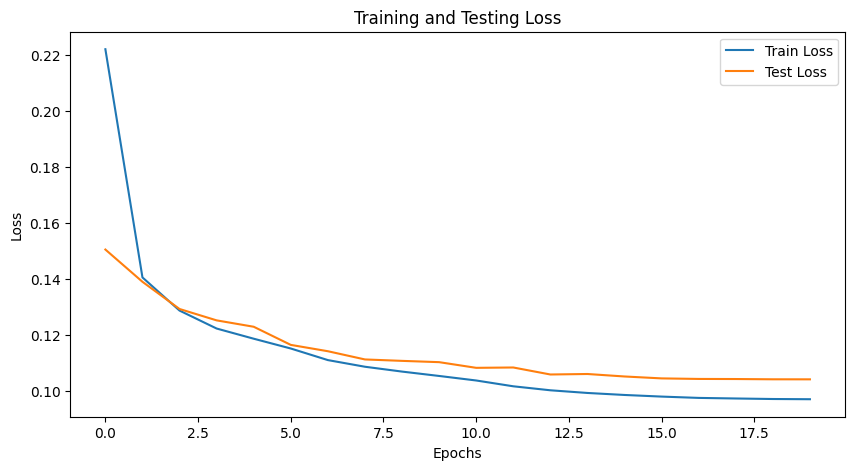

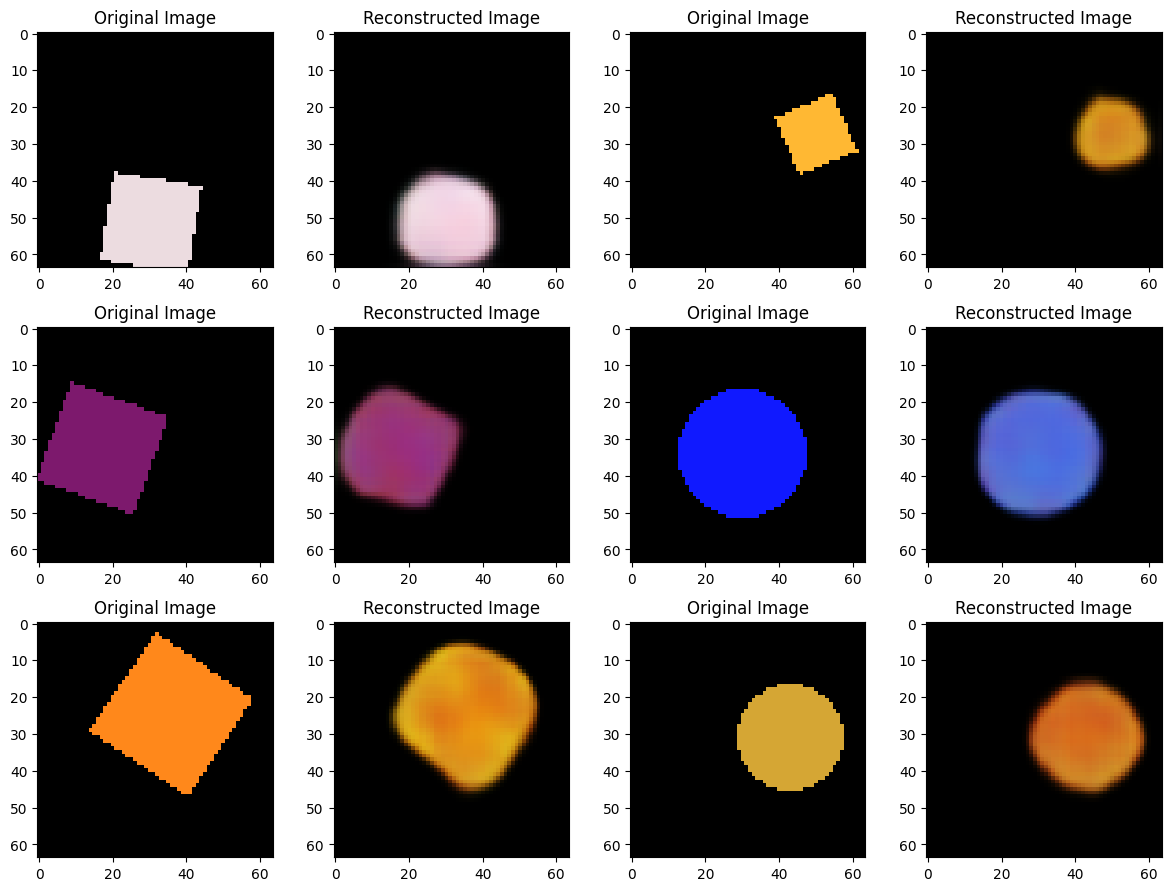

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc1): Linear(in_features=8192, out_features=8, bias=True)
   (layer_norm): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
   (fc2): Linear(in_features=8, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
     (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(

In [5]:
train_model(8)

Number of parameters: 604339
Epoch [1/20], Train Loss: 0.2134, Test Loss: 0.1472
Epoch [2/20], Train Loss: 0.1353, Test Loss: 0.1325
Epoch [3/20], Train Loss: 0.1248, Test Loss: 0.1264
Epoch [4/20], Train Loss: 0.1192, Test Loss: 0.1231
Epoch [5/20], Train Loss: 0.1152, Test Loss: 0.1196
Epoch [6/20], Train Loss: 0.1126, Test Loss: 0.1167
Epoch [7/20], Train Loss: 0.1082, Test Loss: 0.1095
Epoch [8/20], Train Loss: 0.1020, Test Loss: 0.1043
Epoch [9/20], Train Loss: 0.0953, Test Loss: 0.0971
Epoch [10/20], Train Loss: 0.0909, Test Loss: 0.0945
Epoch [11/20], Train Loss: 0.0888, Test Loss: 0.0909
Epoch [12/20], Train Loss: 0.0857, Test Loss: 0.0890
Epoch [13/20], Train Loss: 0.0840, Test Loss: 0.0881
Epoch [14/20], Train Loss: 0.0830, Test Loss: 0.0867
Epoch [15/20], Train Loss: 0.0821, Test Loss: 0.0862
Epoch [16/20], Train Loss: 0.0814, Test Loss: 0.0859
Epoch [17/20], Train Loss: 0.0808, Test Loss: 0.0856
Epoch [18/20], Train Loss: 0.0805, Test Loss: 0.0854
Epoch [19/20], Train Loss:

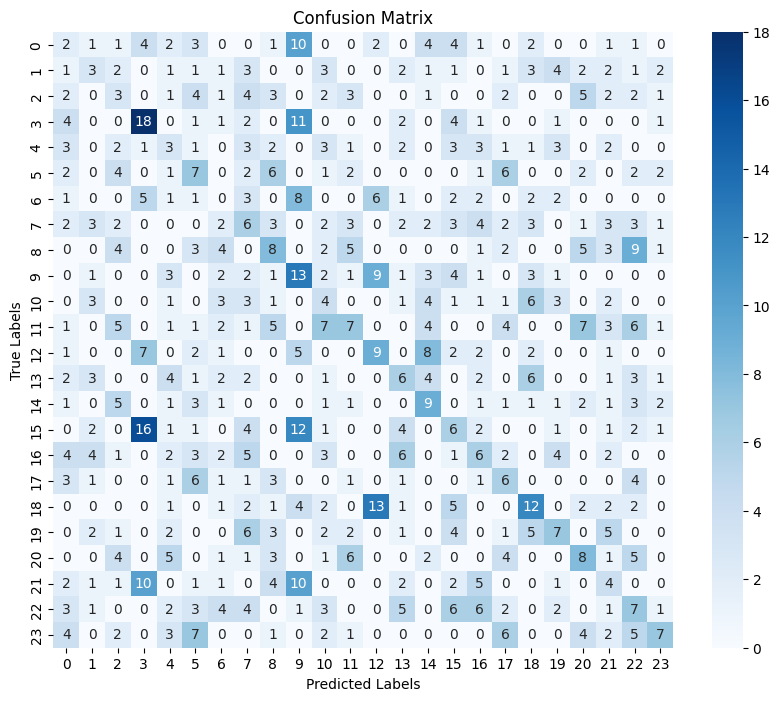

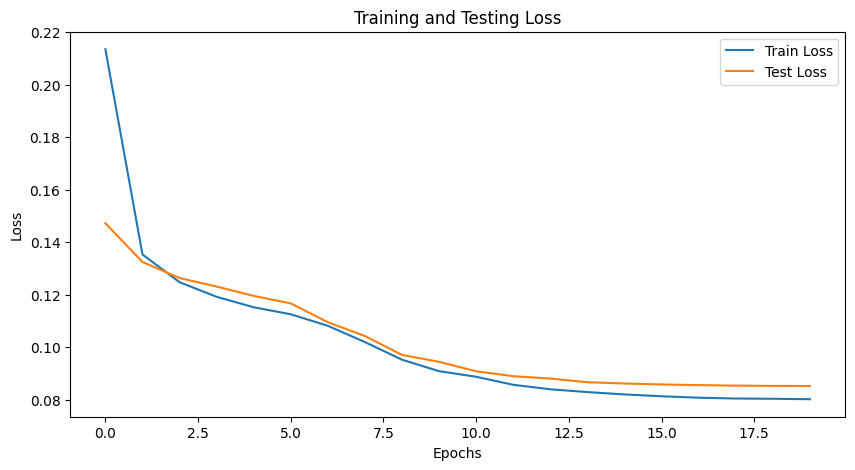

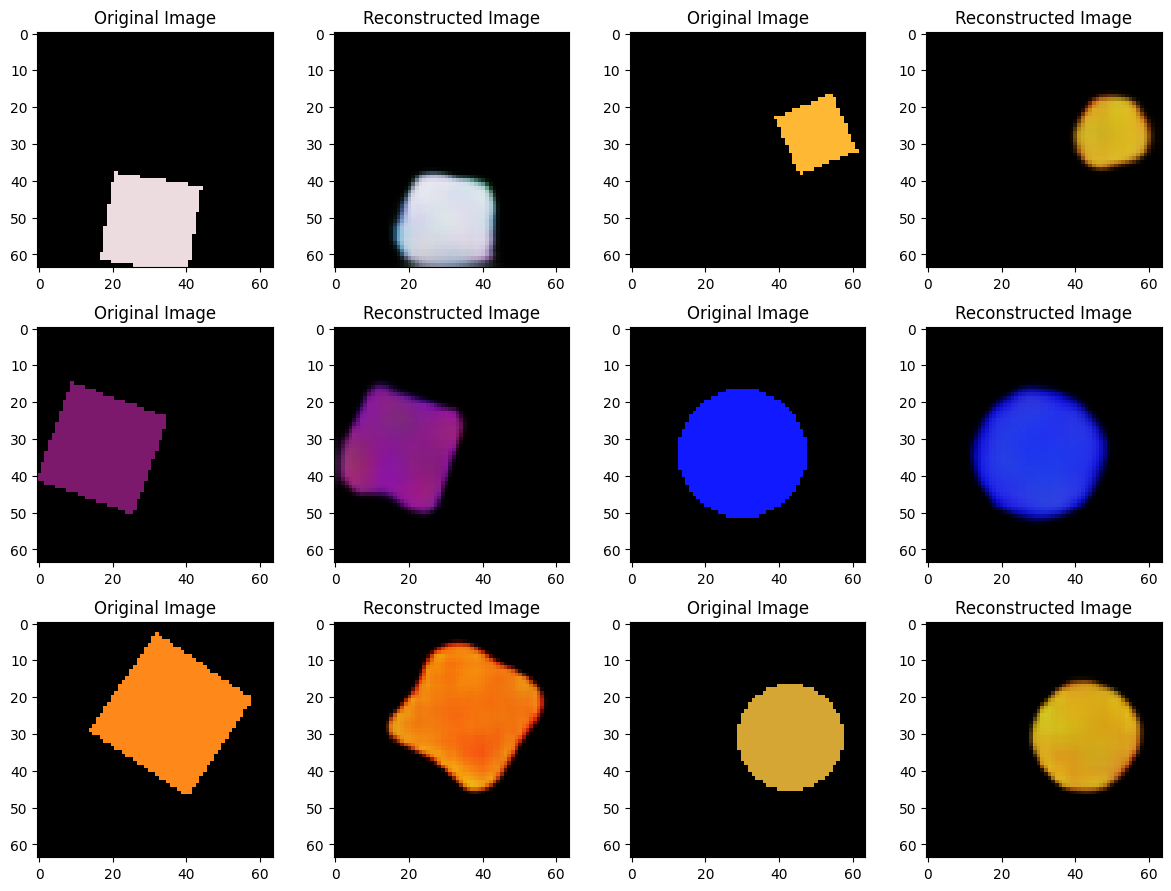

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc1): Linear(in_features=8192, out_features=16, bias=True)
   (layer_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
   (fc2): Linear(in_features=16, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
     (3): Conv2d(128, 64, kernel_size=(3, 3), strid

In [6]:
train_model(16)

Number of parameters: 866531
Epoch [1/20], Train Loss: 0.2294, Test Loss: 0.1466
Epoch [2/20], Train Loss: 0.1336, Test Loss: 0.1326
Epoch [3/20], Train Loss: 0.1232, Test Loss: 0.1238
Epoch [4/20], Train Loss: 0.1143, Test Loss: 0.1113
Epoch [5/20], Train Loss: 0.1013, Test Loss: 0.1010
Epoch [6/20], Train Loss: 0.0933, Test Loss: 0.0963
Epoch [7/20], Train Loss: 0.0893, Test Loss: 0.0939
Epoch [8/20], Train Loss: 0.0865, Test Loss: 0.0910
Epoch [9/20], Train Loss: 0.0842, Test Loss: 0.0877
Epoch [10/20], Train Loss: 0.0814, Test Loss: 0.0842
Epoch [11/20], Train Loss: 0.0787, Test Loss: 0.0819
Epoch [12/20], Train Loss: 0.0772, Test Loss: 0.0807
Epoch [13/20], Train Loss: 0.0759, Test Loss: 0.0795
Epoch [14/20], Train Loss: 0.0751, Test Loss: 0.0789
Epoch [15/20], Train Loss: 0.0745, Test Loss: 0.0786
Epoch [16/20], Train Loss: 0.0742, Test Loss: 0.0782
Epoch [17/20], Train Loss: 0.0739, Test Loss: 0.0780
Epoch [18/20], Train Loss: 0.0737, Test Loss: 0.0779
Epoch [19/20], Train Loss:

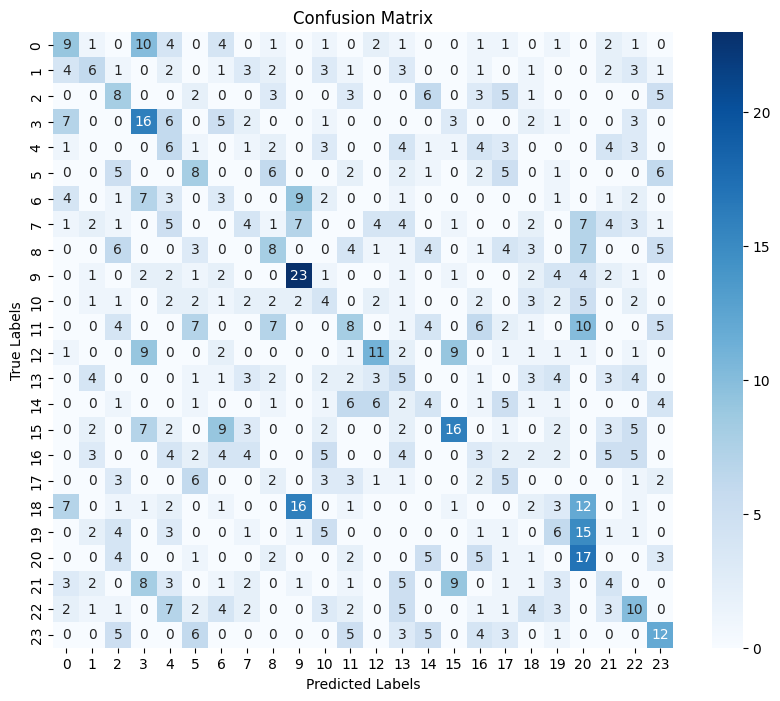

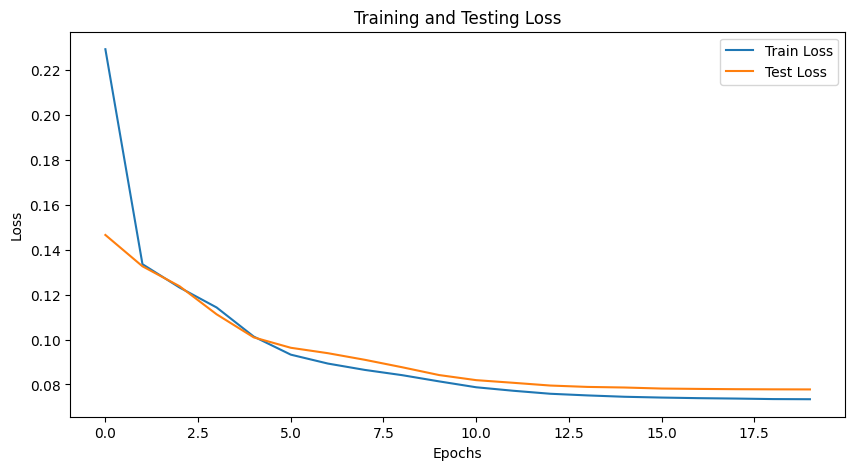

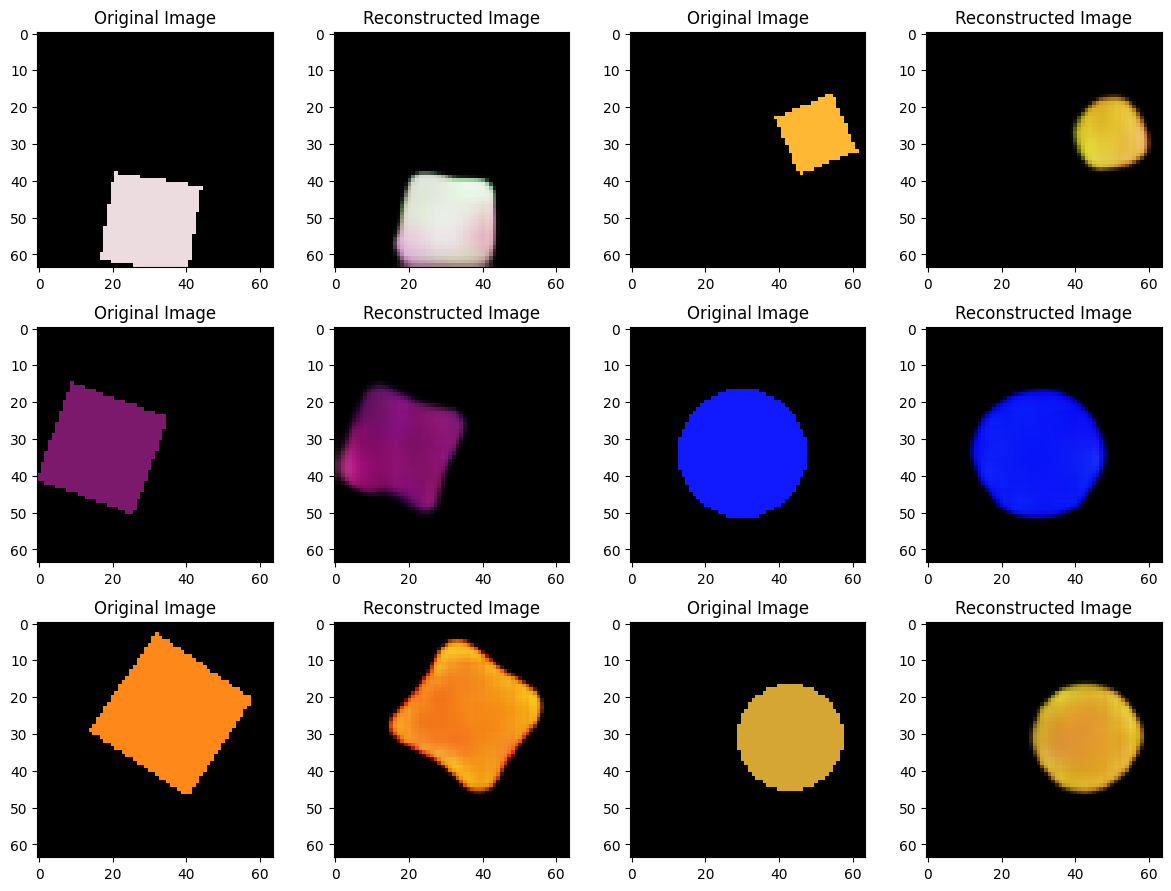

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc1): Linear(in_features=8192, out_features=32, bias=True)
   (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
   (fc2): Linear(in_features=32, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
     (3): Conv2d(128, 64, kernel_size=(3, 3), strid

In [7]:
train_model(32)

Number of parameters: 1390915
Epoch [1/20], Train Loss: 0.2083, Test Loss: 0.1432
Epoch [2/20], Train Loss: 0.1298, Test Loss: 0.1280
Epoch [3/20], Train Loss: 0.1172, Test Loss: 0.1103
Epoch [4/20], Train Loss: 0.1002, Test Loss: 0.1005
Epoch [5/20], Train Loss: 0.0941, Test Loss: 0.0961
Epoch [6/20], Train Loss: 0.0878, Test Loss: 0.0866
Epoch [7/20], Train Loss: 0.0807, Test Loss: 0.0845
Epoch [8/20], Train Loss: 0.0780, Test Loss: 0.0810
Epoch [9/20], Train Loss: 0.0764, Test Loss: 0.0796
Epoch [10/20], Train Loss: 0.0752, Test Loss: 0.0784
Epoch [11/20], Train Loss: 0.0742, Test Loss: 0.0775
Epoch [12/20], Train Loss: 0.0734, Test Loss: 0.0772
Epoch [13/20], Train Loss: 0.0729, Test Loss: 0.0768
Epoch [14/20], Train Loss: 0.0726, Test Loss: 0.0763
Epoch [15/20], Train Loss: 0.0720, Test Loss: 0.0760
Epoch [16/20], Train Loss: 0.0718, Test Loss: 0.0759
Epoch [17/20], Train Loss: 0.0716, Test Loss: 0.0757
Epoch [18/20], Train Loss: 0.0714, Test Loss: 0.0756
Epoch [19/20], Train Loss

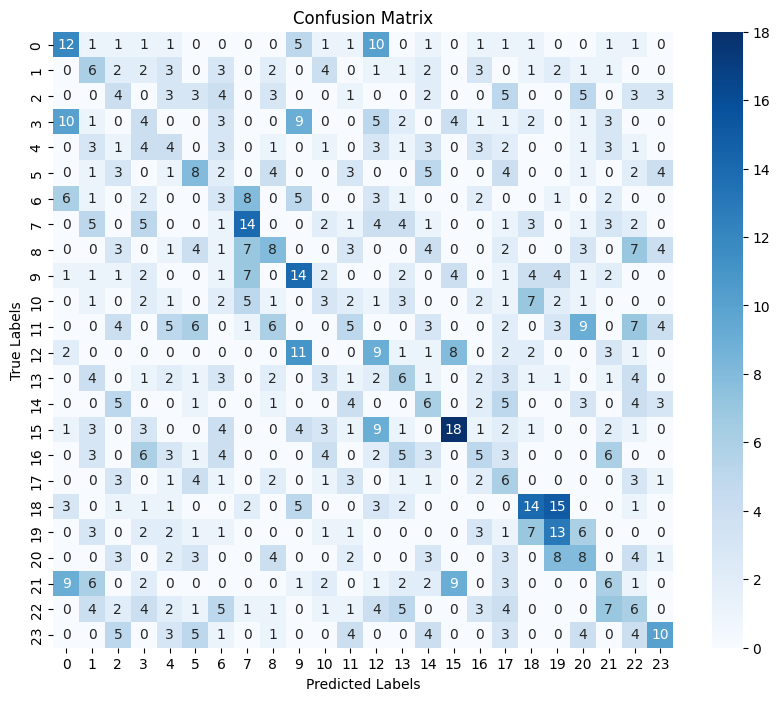

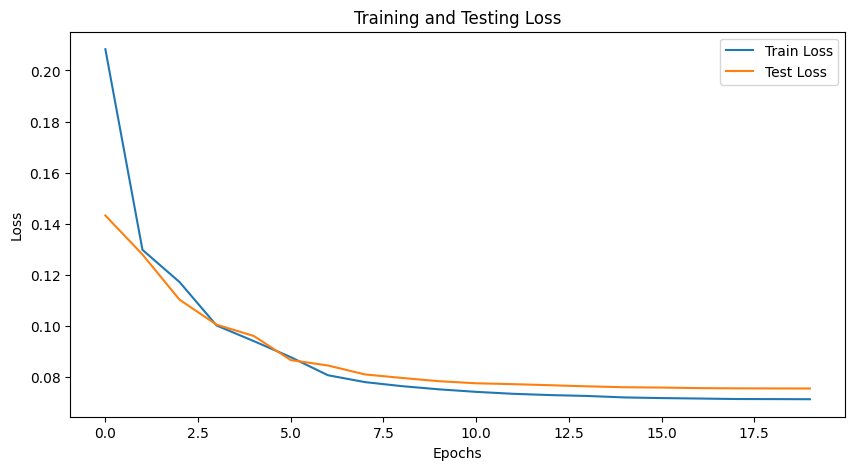

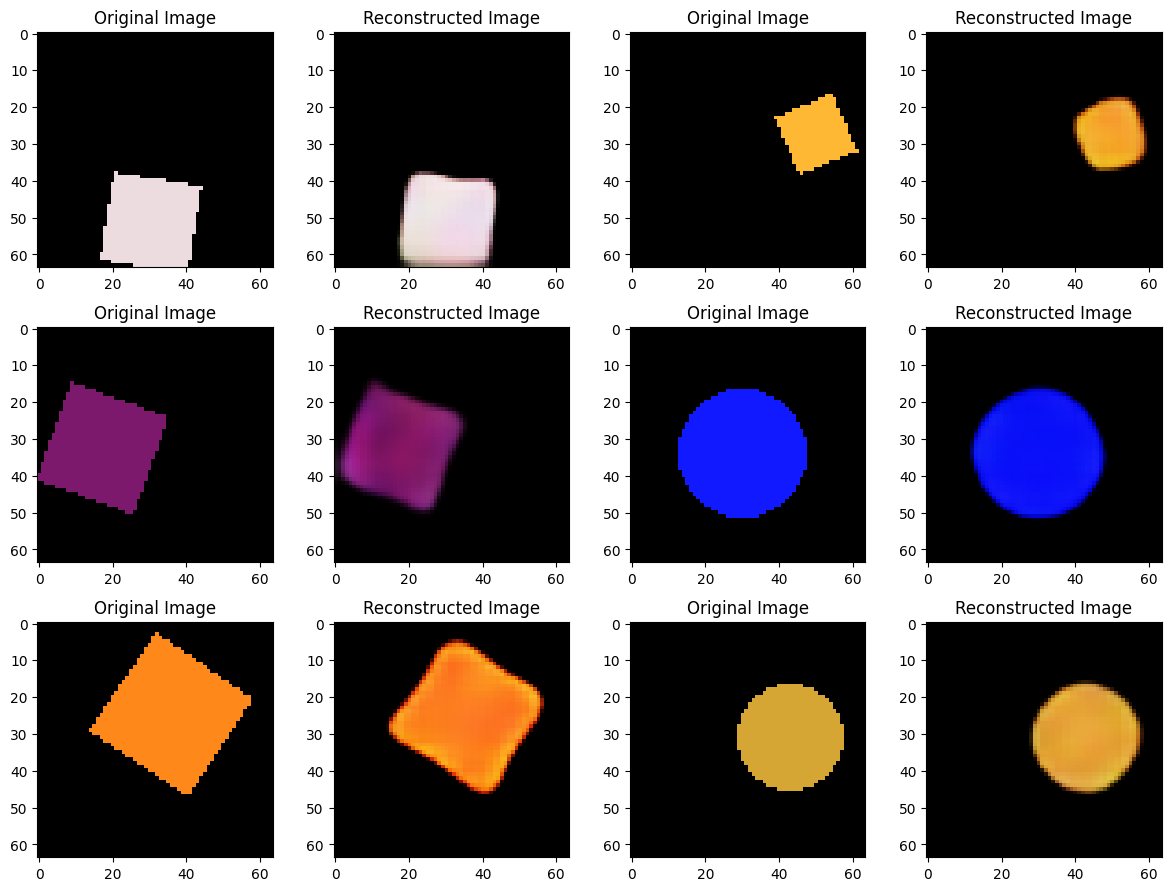

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc1): Linear(in_features=8192, out_features=64, bias=True)
   (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
   (fc2): Linear(in_features=64, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
     (3): Conv2d(128, 64, kernel_size=(3, 3), strid

In [8]:
train_model(64)